<a href="https://colab.research.google.com/github/rmezapi/dementia_vit/blob/main/Dementia_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project was intended to test the limits of the ViT on a tough dementia dataset. The data used can be found on HuggingFace at: https://huggingface.co/datasets/Falah/Alzheimer_MRI. The project follows closely the following tutorials:


*   https://www.youtube.com/watch?v=r88L_yLJ4CE&ab_channel=code_your_own_AI
*   https://www.youtube.com/watch?v=qU7wO02urYU&ab_channel=JamesBriggs  


I modify the code presented in the video and tune all parameters to optimize performance using mostly the same libraries and tools. This is a practice project for myself as I return to coding/designing ML models after dedicating time to AI/ML theory (model architectures, transfer learning)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install torch torchvision
import torch
import torchvision

!pip install -q transformers datasets



In [2]:
from transformers import ViTConfig, ViTModel

# initalizing a ViT vit-patch-base16-224 configuration
config = ViTConfig()
# initialize a model w random weights
model = ViTModel(config)
# access the model config
config = model.config

In [3]:
config

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.26.0"
}

In [4]:
model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [5]:
from transformers import ViTImageProcessor

from datasets import load_dataset

dataset = load_dataset("Falah/Alzheimer_MRI")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


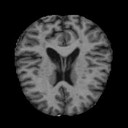

In [6]:
# preview the 1st image
image = dataset["train"][0]["image"]
image

In [7]:
# construct a ViT image processor
features = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# load pretrained model on imagenet-21k
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
features.rescale_factor = 1
features.size = 224

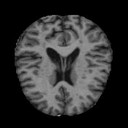

In [9]:
# add channels to image
image = image.convert(mode="RGB")

image

In [10]:
inputs = features(image, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

In [11]:
last_hidden_state = outputs.last_hidden_state
last_hidden_state.shape

torch.Size([1, 197, 768])

In [12]:
model.config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.26.0"
}

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
def preprocess(batch):
  # Convert the images to RGB format (3 channels)
  images = [image.convert("RGB") for image in batch["image"]]

  # take a list of images and turn them into pixel values
  inputs = features(images, return_tensors="pt")
  # Check if the 'image' key is present
  if "image" in inputs:
      inputs.pop("image")

  # include the labels
  inputs["labels"] = batch["label"]
  return inputs

In [15]:
prepared_train = dataset["train"].with_transform(preprocess)
prepared_test = dataset["test"].with_transform(preprocess)

In [16]:
# collate function
def collate(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch])
  }

In [17]:
from datasets import load_metric

metric = load_metric("accuracy")
def metric_fn(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

<ipython-input-17-e76decef833c>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [18]:
# !pip install pytorch-accelerated
!pip uninstall accelerate -y
!pip install accelerate==0.21.0
!pip install transformers==4.26.0
!pip install transformers[torch]

Found existing installation: accelerate 0.21.0
Uninstalling accelerate-0.21.0:
  Successfully uninstalled accelerate-0.21.0
  Using cached accelerate-0.21.0-py3-none-any.whl (244 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-accelerated 0.1.49 requires accelerate==0.29.3, but you have accelerate 0.21.0 which is incompatible.


In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./dementia",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.001,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    save_total_limit=3,
    logging_steps=1,
    save_steps=1,
    remove_unused_columns=False
)

In [20]:
from transformers import ViTForImageClassification

# we have to make the custom labels here!
labels = dataset["train"].features["label"].names
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not in

In [21]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=features,
    data_collator=collate,
    compute_metrics=metric_fn
)

In [23]:
# train and store results
train_results = trainer.train()
# save tokenizer w the model
trainer.save_model()
# log and save metrics
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5120
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1600
  Number of trainable parameters = 85801732
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.821500,0.925772,0.551562
2,0.698200,0.904959,0.561719
3,0.734600,1.034166,0.545312
4,0.551700,0.853011,0.597656


size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the followi

Epoch,Training Loss,Validation Loss,Accuracy
1,0.821500,0.925772,0.551562
2,0.698200,0.904959,0.561719
3,0.734600,1.034166,0.545312
4,0.551700,0.853011,0.597656
5,0.749900,0.836934,0.628906


size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the followi

***** train metrics *****
  epoch                    =          5.0
  total_flos               = 1847586123GF
  train_loss               =         0.87
  train_runtime            =   0:05:33.32
  train_samples_per_second =       76.802
  train_steps_per_second   =          4.8


In [24]:
# view eval metrics
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 1280
  Batch size = 8
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.


size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
size should be a dictionary on of the followi

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.6289
  eval_loss               =     0.8369
  eval_runtime            = 0:00:07.00
  eval_samples_per_second =    182.775
  eval_steps_per_second   =     22.847


Ground Truth: Very_Mild_Demented (3)


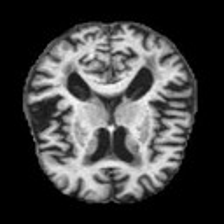

In [27]:
import random
from random import randint
n_sample = randint(0, len(dataset["test"]))
image = dataset["test"][n_sample]["image"].resize((224, 224))

# 0: mild_demented, 1: moderate_demented, 2: non_demented, 3: very_mild_demented

ground_truth = dataset["test"][n_sample]["label"]

print(f"Ground Truth: {labels[ground_truth]} ({ground_truth})")
image

In [28]:
# check the model output
image = image.convert("RGB")
inputs = features(image, return_tensors="pt").to(device)
with torch.no_grad():
  outputs = model(**inputs).logits

predicted_label = torch.argmax(outputs).item()
predicted_label, labels[predicted_label]

size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.


(3, 'Very_Mild_Demented')